In [2]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/f

In [3]:
image_vec_shape = 12
gait_key_poses = 16
conditional_vec_shape = 10
pose_image_shape = (160,120,1)
full_vec_shape = image_vec_shape+conditional_vec_shape
n_timesteps = 3

In [4]:
model_OneRNN = keras.models.Sequential()
model_BiRNN = keras.models.Sequential()
model_ConvRNN = keras.models.Sequential()

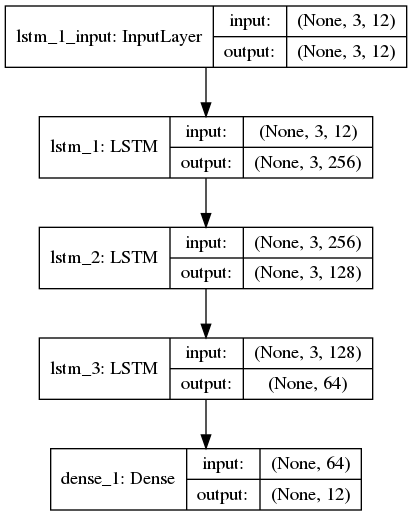

In [5]:
model_OneRNN = keras.models.Sequential()
model_OneRNN.add(keras.layers.LSTM(256,
                                   activation='tanh',
                                   return_sequences=True,
                                   input_shape=(n_timesteps,
                                                image_vec_shape)
                                  ))
#model_OneRNN.add(keras.layers.LSTM(256,
#                                   activation='tanh',
#                                   return_sequences=True
#                                  ))
model_OneRNN.add(keras.layers.LSTM(128,
                                   activation='tanh',
                                   return_sequences=True
                                  ))
model_OneRNN.add(keras.layers.LSTM(64,
                                   activation='tanh'
                                  ))
model_OneRNN.add(keras.layers.Dense(image_vec_shape,
                                    activation='linear'
                                  ))
model_OneRNN.compile(optimizer='adam', loss='mse')
plot_model(model_OneRNN, to_file='model_OneRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_OneRNN_plot.png')
im

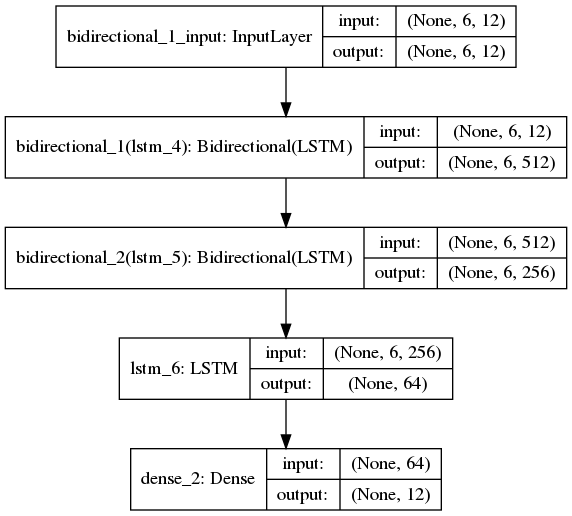

In [6]:
model_BiRNN = keras.models.Sequential()
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(256,
                                      activation='tanh',
                                      return_sequences=True),
                                      input_shape=(2*n_timesteps,image_vec_shape)
                ))
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(128,
                                      activation='tanh',
                                      return_sequences=True)
                ))
model_BiRNN.add(keras.layers.LSTM(64,
                                  activation='tanh'
                                 ))
model_BiRNN.add(keras.layers.Dense(image_vec_shape))
model_BiRNN.compile(optimizer='adam', loss='mse')
plot_model(model_BiRNN, to_file='model_BiRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_BiRNN_plot.png')
im

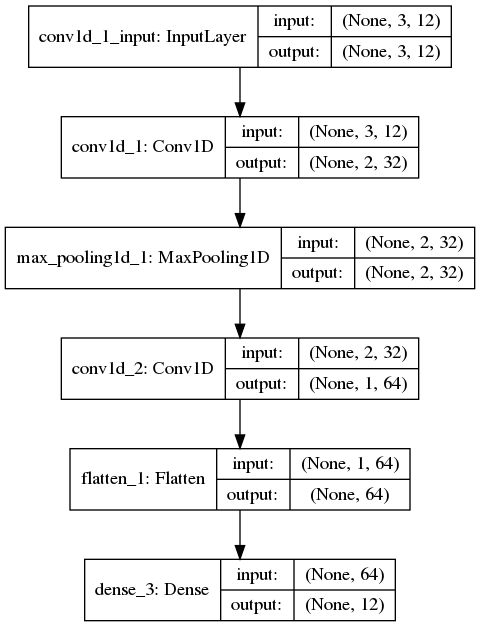

In [7]:
model_ConvRNN = keras.models.Sequential()
model_ConvRNN.add(keras.layers.Conv1D(filters=32,
                                        kernel_size = 2,
                                        activation='tanh',
                                        input_shape=(n_timesteps, image_vec_shape)
                                     ))
model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=1))
model_ConvRNN.add(keras.layers.Conv1D(filters=64,
                                      kernel_size= 2,
                                      activation='tanh'))
#model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_ConvRNN.add(keras.layers.Flatten())
model_ConvRNN.add(keras.layers.Dense(image_vec_shape))
model_ConvRNN.compile(optimizer='adam', loss='mse')
plot_model(model_ConvRNN, to_file='model_ConvRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_ConvRNN_plot.png')
im

In [60]:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(15, image_vec_shape), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.)*eps
def encoder_model():
    x_in = keras.layers.Input(shape=pose_image_shape)
    condition_in = keras.layers.Input(shape=(gait_key_poses,))
    condi_vec1 = keras.layers.Dense(8)(condition_in)
    condi_vec = keras.layers.Dense(4)(condi_vec1)
    x = keras.layers.Conv2D(filters=16,
                            kernel_size=(7,7),
                            strides=(3,3),
                            activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x,training=True)
    x = keras.layers.Conv2D(filters=32,
                            kernel_size=(7,7),
                            strides=(3,3),
                            activation='relu')(x)
    x = keras.layers.BatchNormalization()(x, training=True)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(5,5),
                            strides=(2,2),
                            activation='relu')(x)
    x = keras.layers.BatchNormalization()(x, training=True)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(336, activation='relu')(x)
    x_vec = keras.layers.concatenate([x,condi_vec])
    x_vec = keras.layers.Dense(32, activation='relu')(x_vec)
    mu = keras.layers.Dense(image_vec_shape, activation='linear')(x_vec)
    log_var = keras.layers.Dense(image_vec_shape, activation='linear')(x_vec)
    z = keras.layers.Lambda(sampling, output_shape=(image_vec_shape,))([mu,log_var])
    z_cond = keras.layers.concatenate([z, condi_vec])
    
    encoder = keras.models.Model([x_in,condition_in], z_cond)
    
    z1 = keras.layers.Dense(32, activation='relu')(z_cond)
    z1 = keras.layers.Dense(336, activation='relu')(z1)
    z1 = keras.layers.Dense(1536, activation='relu')(z1)
    zim = keras.layers.Reshape((6,4,64))(z1)
    zim = keras.layers.Conv2DTranspose(filters=32,
                                       kernel_size=(5,5),
                                       strides=(2,2),
                                       activation='relu')(zim)
    zim = keras.layers.Dropout(0.1)(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=16,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu')(zim)
    zim = keras.layers.Dropout(0.1)(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=3,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu')(zim)
    zim = keras.layers.Dropout(0.1)(zim, training=True)
    zim = keras.layers.Conv2D(filters=1,
                              kernel_size=(2,2),
                              activation='tanh')(zim)
    
    decoder = keras.models.Model([x_in, condition_in], zim)
    #encoder.compile(optimizer='adam',loss='mse')
    
    
    return encoder, decoder
CVAE, CVAE_FULL = encoder_model()

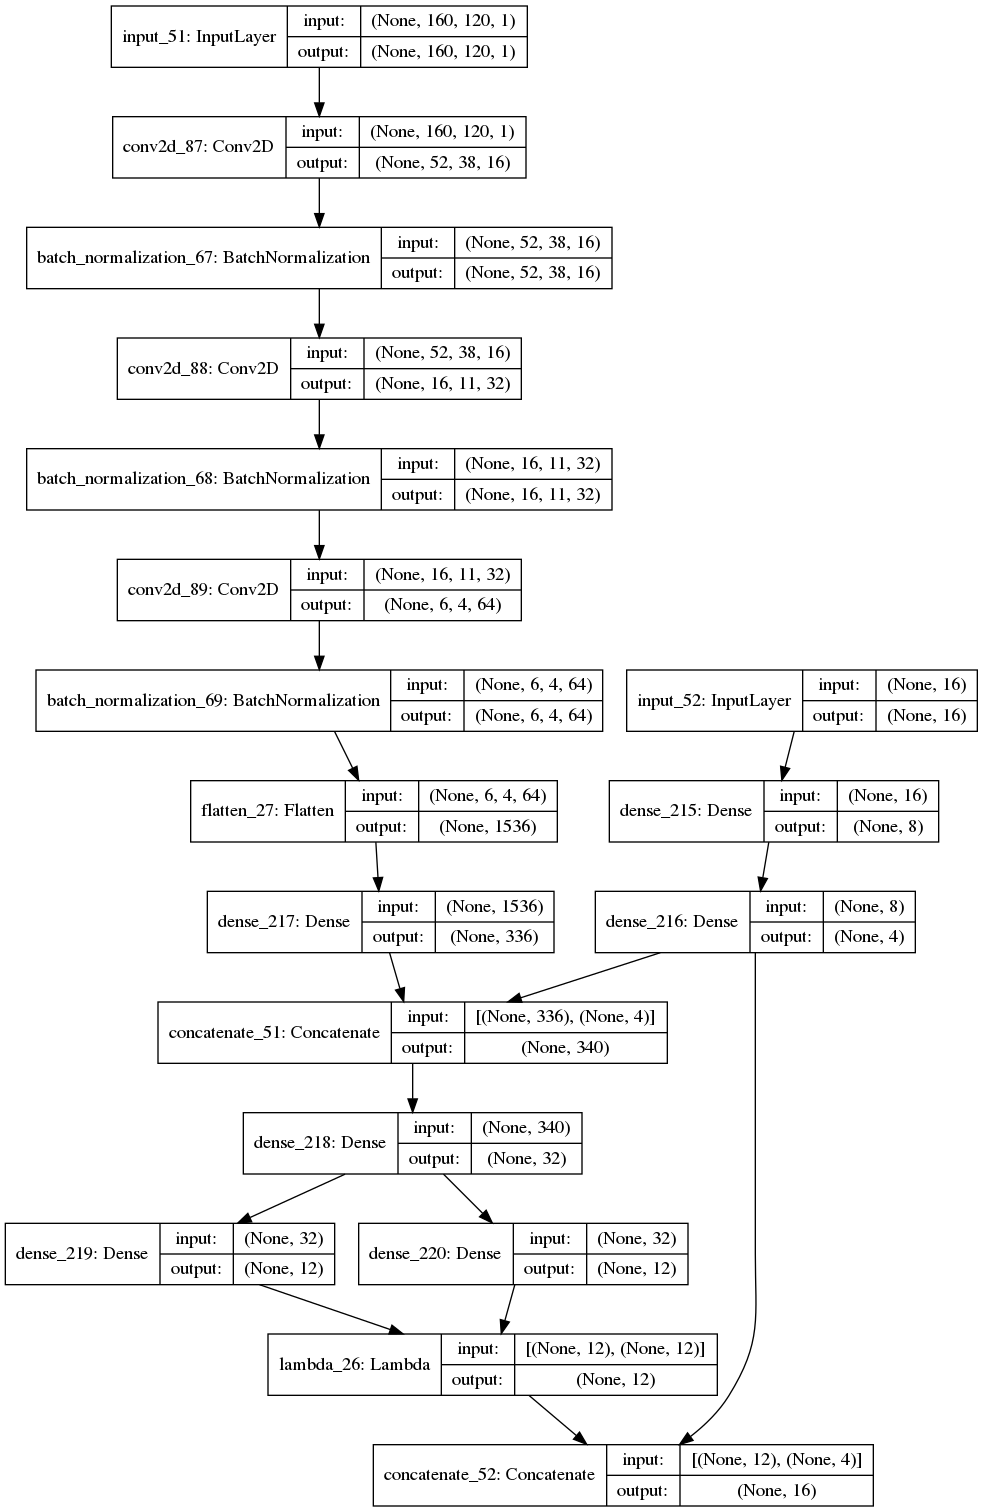

In [61]:
plot_model(CVAE, to_file='CVAE.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE.png')
im

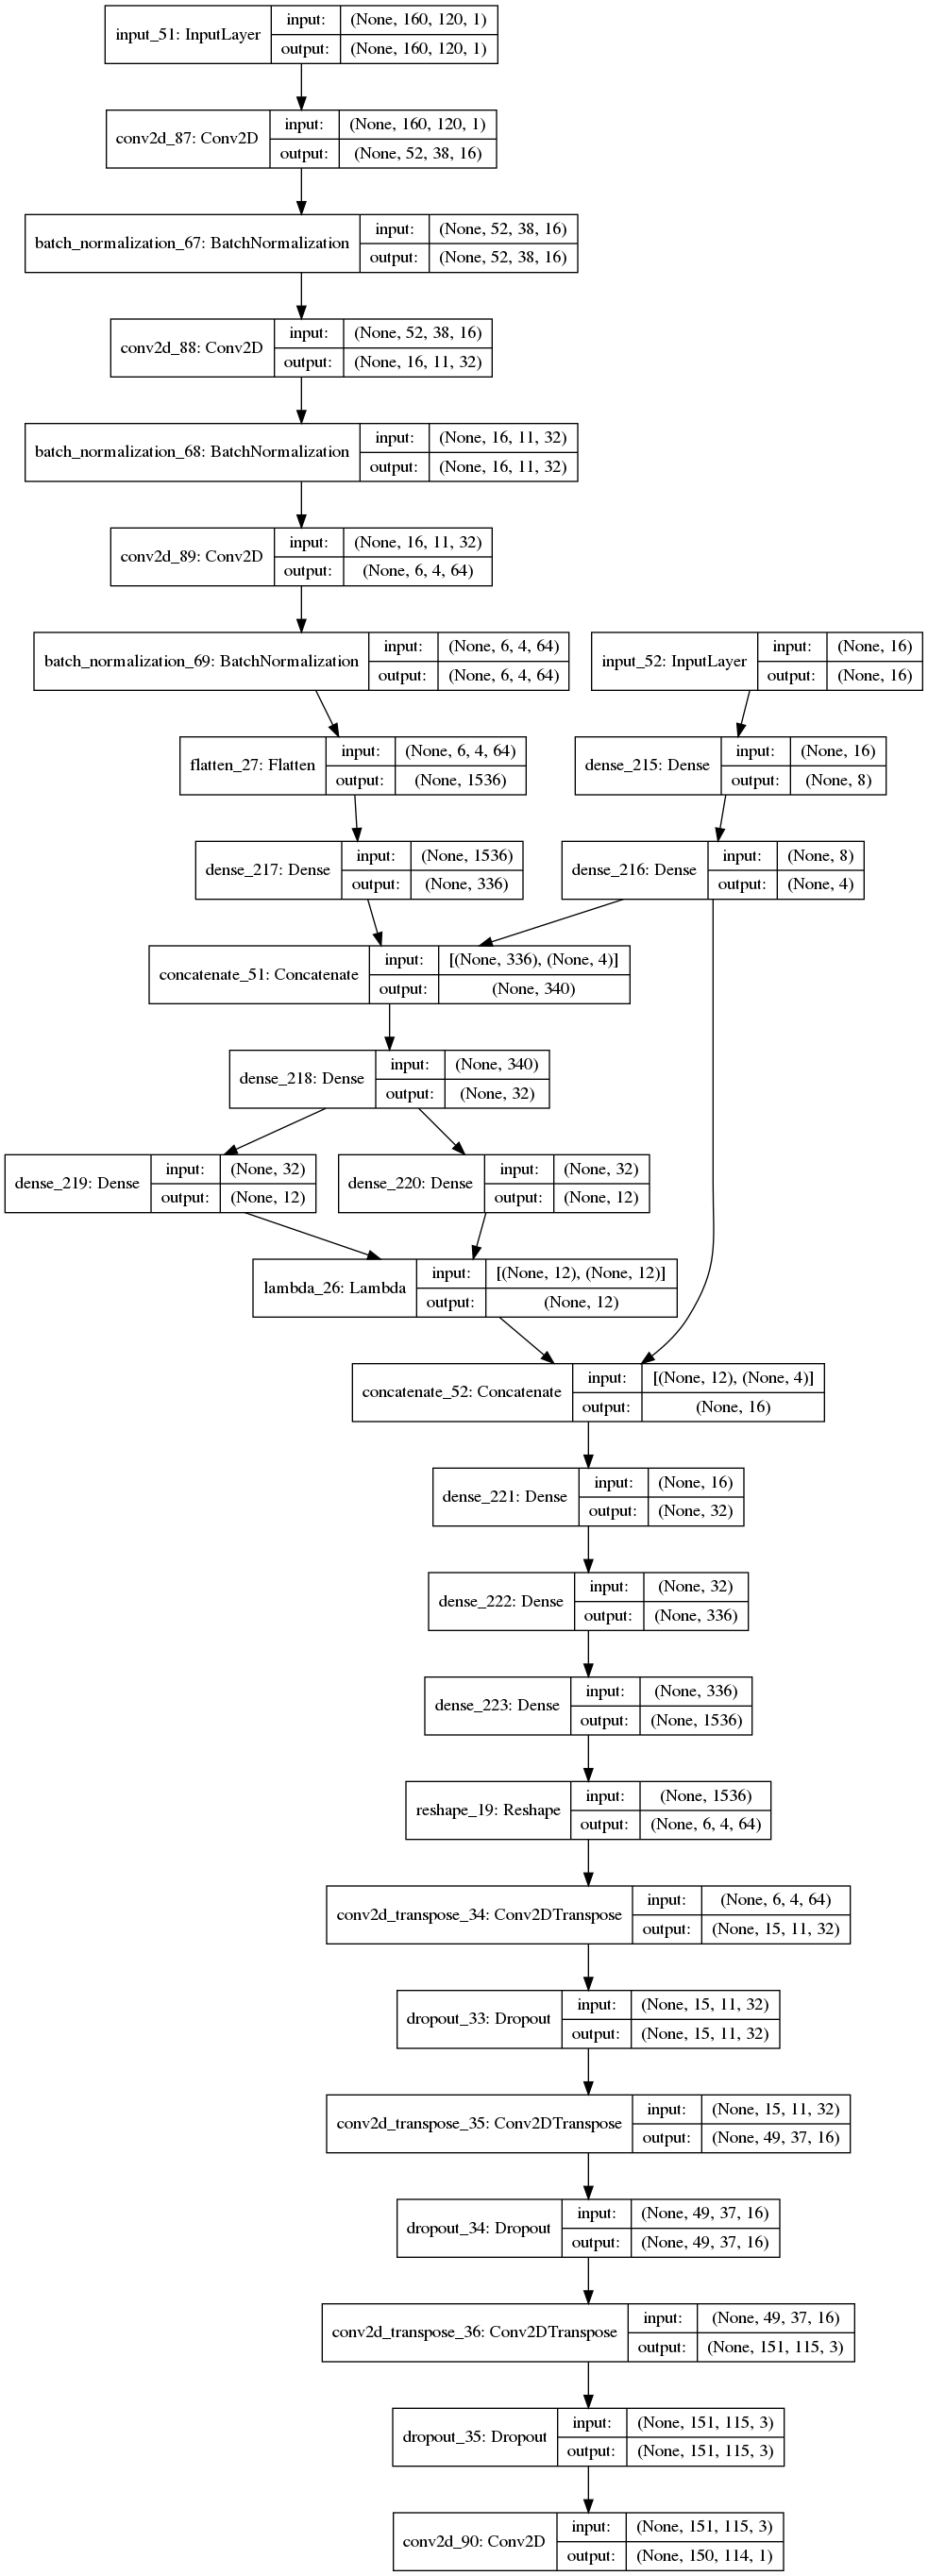

In [62]:
plot_model(CVAE_FULL, to_file='CVAE_FULL.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE_FULL.png')
im